# Imports

In [17]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

from nnn.uv import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 640x480 with 0 Axes>

# Data cleaning

In [18]:
# copy pasted from command center for convenience
# only one peak found by AnalyzePeaks
hplc_clean_seqid = ["WC68_stem_3p", "WC68_stem_5p", "WC1025_split_5p", \
"WC1025_split_3p", "WC1375_stem_5p", "WC1375_stem_3p", "DMM004_5p", \
"DMM004_3p", "DMM005_5p", "DMM005_3p", "DMM006_5p", "DMM007_5p", \
"DMM007_3p", "BC0", "BC1", "BC6", "BC7", "BC8", "BC9", "BC10", \
"BC11", "MMCNNN2328", "MMCNNN2331", "MMCNNN2334", "MMCNNN2335", \
"MMCNNN2336", "MMCNNN2337", "MMTM1325", "MMTM176", "MMTM178", \
"MMTM179", "MMTM181", "MMTM185", "MMTM189", "MMTM1917", "MMTM29", \
"MMTM397", "MMTM509", "MMTM877", "DMM003_3p_rc", "DMM004_3p_rc", \
"DMM005_3p_rc", "DMM006_3p_rc", "DMM007_3p_rc", "TETNN1003", \
"TETNN999", "TETNN963", "TETNN979", "TETNNN1696", "TETNNN2082", \
"TETNNN1570", "HP002", "HP003", "HP004", "HP005", "HP007", "HP008", \
"HP010", "HP011", "HP012", "HP014", "HP015", "HP016", "HP017", \
"HP018", "HP019", "HP021", "HP022", "HP023", "HP024"]


297 / 387 single curves passed QC




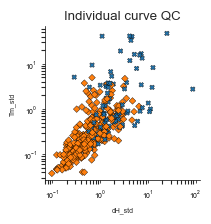

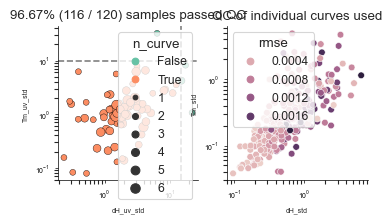

In [32]:
sample_sheet_file = './data/uv_melt/ECLTables/ECLSampleSheet.csv'
datadir="./data/uv_melt/ECLExportAuto"
result_file='./data/uv_melt/uvmelt_single.csv'
agg_result_file='./data/uv_melt/uvmelt_agg.csv'

result_df = pd.read_csv(result_file, index_col=0)
result_agg_df = agg_fit_result(uvmelt_result_file=result_file,
                               agg_result_file=agg_result_file,
                               single_curve_qc_criteria='rmse < 0.002 & dH_std < 10 & Tm_std < 5 & dH < 0 & dH > -100 & Tm > 0 & Tm < 120',
                               Tm_std_thresh=10, dH_std_thresh=15,
                               sample_sheet_file=sample_sheet_file, 
                               clean=True, only_use_cooling=False)
util.save_multi_image('./fig/Fig2/uv_qc.pdf')

In [20]:
### Accounting ###

n_seq = len(np.unique(result_agg_df.SEQID))
n_clean_seq = np.sum(result_agg_df.SEQID.isin(hplc_clean_seqid))
print(f'There are {n_seq} unique sequence variants in total, {n_clean_seq} are clean by HPLC.')

is_hp = result_agg_df.SEQID.apply(lambda x: x.startswith('HP'))
print(f'  - Of the {n_seq} variants, {np.sum(is_hp)} are de novo hairpins, and {n_seq - np.sum(is_hp)} are in the Array Melt library.')

is_hp = result_agg_df.SEQID[result_agg_df.SEQID.isin(hplc_clean_seqid)].apply(lambda x: x.startswith('HP'))
print(f'  - Of the {n_clean_seq} HPLC-clean variants, {np.sum(is_hp)} are de novo hairpins, and {n_clean_seq - np.sum(is_hp)} are in the Array Melt library.')

print(f'\nOf the {n_seq} variants:')
conc, counts = np.unique(result_agg_df.Na_mM, return_counts=True)
for Na_mM, count in zip(conc, counts):
    print(f'  - {count} samples were measured at {Na_mM} mM NaCl, 50 mM HEPES, pH8.0')
    
print(f'\nOf the {n_clean_seq} HPLC-clean variants:')
conc, counts = np.unique(result_agg_df[result_agg_df.SEQID.isin(hplc_clean_seqid)].Na_mM, return_counts=True)
for Na_mM, count in zip(conc, counts):
    print(f'  - {count} samples were measured at {Na_mM} mM NaCl, 50 mM HEPES, pH8.0')
    
_, counts = np.unique(result_agg_df.SEQID[result_agg_df.SEQID.isin(hplc_clean_seqid)].apply(lambda x: x.startswith('HP')), return_counts=True)
print(counts)

There are 85 unique sequence variants in total, 24 are clean by HPLC.
  - Of the 85 variants, 19 are de novo hairpins, and 66 are in the Array Melt library.
  - Of the 24 HPLC-clean variants, 12 are de novo hairpins, and 12 are in the Array Melt library.

Of the 85 variants:
  - 87 samples were measured at 25.0 mM NaCl, 50 mM HEPES, pH8.0
  - 7 samples were measured at 50.0 mM NaCl, 50 mM HEPES, pH8.0
  - 22 samples were measured at 1000.0 mM NaCl, 50 mM HEPES, pH8.0

Of the 24 HPLC-clean variants:
  - 24 samples were measured at 25.0 mM NaCl, 50 mM HEPES, pH8.0
[12 12]


In [41]:
result_agg_df = result_agg_df[result_agg_df.SEQID.isin(hplc_clean_seqid)]

arr = pd.read_csv('./data/models/raw/arr_v0_n=30872.csv', index_col=0)
vf = result_agg_df.query('is_hairpin & Na_mM == 25').sort_values(by=['conc_uM', 'n_curve', 'curve_date']).drop_duplicates(keep='last').merge(arr, how='left', on='SEQID')



In [42]:
vf

,SEQID,curve_date,curve_num,dH_uv,dH_uv_std,n_curve,Tm_uv,Tm_uv_std,dG_37_uv,dG_37_uv_std,...,dG_37_ensemble_NUPACK,TargetStruct,dG_37_NUPACK,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK,GC,Tm_NUPACK_salt_corrected,dG_37_NUPACK_salt_corrected,dH_NUPACK_salt_corrected,dS_NUPACK_salt_corrected
0,HP014,23020411,2,-29.188951,0.000000,1,39.230761,0.000000,-0.208443,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HP016,23020411,4,-23.410537,0.000000,1,48.590226,0.000000,-0.843331,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HP018,23020411,6,-38.331193,0.000000,1,62.145979,0.000000,-2.874700,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HP019,23020517,1,-44.254994,0.000000,1,28.323514,0.000000,1.273670,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HP023,23020517,5,-33.696133,0.000000,1,28.400352,0.000000,0.960950,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,MMCNNN2336,23020906,2,-51.039304,0.000000,1,60.131877,0.000000,-3.542452,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,MMTM176,23020906,5,-33.259670,0.000000,1,60.404827,0.000000,-2.333760,0.000000,...,-4.532505,((((.((....)).)))),-4.29,-3.396515,-3.017040,50.000000,65.059918,-3.127818,-37.7,-0.107722
7,TETNNN1696,23021722,6,-25.233867,0.000000,1,44.488611,0.000000,-0.594911,0.000000,...,-4.000516,((((((....)))))),-3.71,-3.131158,-2.745105,50.000000,55.418960,-2.393682,-42.7,-0.125713
8,BC0,23021815,5,-24.417998,0.000000,1,78.269157,0.000000,-2.867545,0.000000,...,-6.654079,((((((....)))))),-6.41,-5.707661,-5.300504,56.250000,73.069702,-5.021550,-48.2,-0.134741
9,HP015,23020411,3,-29.711657,0.396712,2,48.281266,6.199074,-1.042789,0.780775,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
result_agg_df.SEQID.values

array(['BC0', 'BNNN2110', 'BNNN3096', 'BNNN8973', 'HP003', 'HP005',
       'HP007', 'HP008', 'HP009', 'HP009', 'HP010', 'HP014', 'HP015',
       'HP016', 'HP018', 'HP019', 'HP021', 'HP023', 'HP029', 'HP038',
       'HP039', 'HP040', 'HP042', 'MMCNN112', 'MMCNN112', 'MMCNN151',
       'MMCNN151', 'MMCNN164', 'MMCNN20', 'MMCNN20', 'MMCNN70', 'MMCNN70',
       'MMCNN88', 'MMCNN88', 'MMCNNN2336', 'MMCNNN2337', 'MMTM1325',
       'MMTM176', 'MMTM177', 'MMTM181', 'MMTM185', 'MMTM189', 'MMTM1917',
       'MMTM29', 'TETNN1015', 'TETNN773', 'TETNN975', 'TETNNN1262',
       'TETNNN1390', 'TETNNN1511', 'TETNNN1570', 'TETNNN1696',
       'TETNNN1847', 'TETNNN1848', 'TETNNN2099', 'TETNNN2253',
       'TETNNN3186', 'TETNNN3276', 'TETNNN449', 'TETNNN615', 'TETNNN621',
       'TETNNN707', 'TETNNN757', 'TRINNN162', 'TRINNN162', 'TRINNN445',
       'TRINNN452', 'TRINNN470', 'TRINNN512', 'TRINNN520', 'TRINNN544',
       'WC1025', 'WC1025', 'WC1025', 'WC1048', 'WC1048', 'WC1048',
       'WC1106', 'WC1154'

# Fig. 2b: Example UV melting curve

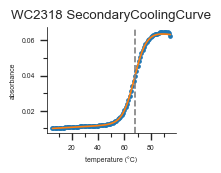

In [22]:
"""
for export
"""
df_2a = result_df.query('curve_date == 22071204 & curve_num == 7')
row = df_2a.iloc[0,:]
fn = row['data_file']
blanked_fn = get_blanked_fn(fn)
if os.path.isfile(blanked_fn):
    fn = blanked_fn
curve = read_curve(fn)
curve_predict = curve_model(curve.celsius, **{x:row[x] for x in ['dH','Tm','fmax','fmin','s1', 's2']})

fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))

row = df_2a.iloc[2,:]
ax.plot(curve.celsius, curve.absorbance, '.')
ax.plot(curve.celsius, 
         curve_predict - curve_predict[0] + curve.absorbance[0])
ax.axvline(row['Tm'], linestyle='--', c='gray')

ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))

ax.set_yticklabels(ax.get_yticklabels(), fontsize=tick_font_size)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=tick_font_size)

ax.set_xlabel('temperature (°C)', fontsize=tick_font_size)
ax.set_ylabel('absorbance', fontsize=tick_font_size)

if 'SEQID' in row.index:
    plt.title('%s %s' % (row['SEQID'], row['curve_name']))
else:
    plt.title('%s' % (row['data_file']))
sns.despine()

util.save_fig('./fig/Fig2/Fig2a/UV_melting_example_curve_WC2318.pdf')

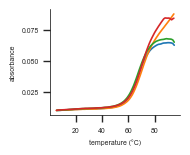

In [23]:
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
for _,row in df_2a.iterrows():
    curve = read_curve(get_blanked_fn(row['data_file']))
    # curve_predict = curve_model(curve.celsius, **{x:row[x] for x in ['dH','Tm','fmax','fmin','s1', 's2']})
    ax.plot(curve.celsius, curve.absorbance)
    
ax.xaxis.set_major_locator(MultipleLocator(20))


ax.set_yticklabels(ax.get_yticklabels(), fontsize=tick_font_size)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=tick_font_size)

ax.set_xlabel('temperature (°C)', fontsize=tick_font_size)
ax.set_ylabel('absorbance', fontsize=tick_font_size)

sns.despine()
util.save_fig('./fig/Fig2/Fig2a/UV_melting_example_all_curves_WC2318.pdf')

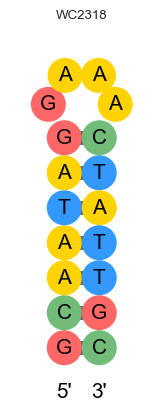

In [24]:
plotting.draw_target_struct('WC2318', arr)
util.save_fig('./fig/Fig2/UV_melting_example_curve_WC2318_struct.pdf')

# Fig. 2d: Direct comparison

In [25]:
def to_rgb(x):
    return np.array(x) / 256.

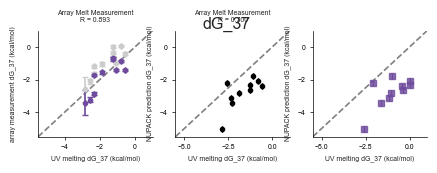

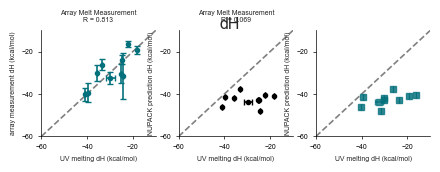

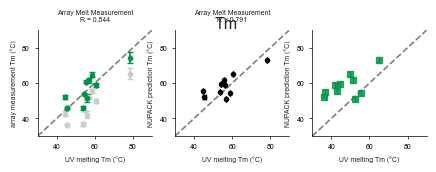

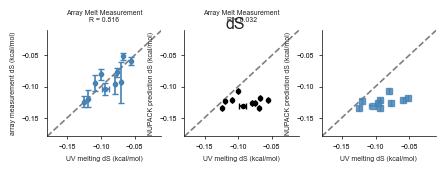

In [43]:
# for export
series = 'All'
plot_query = 'n_curve > 0'
df_q = vf.dropna(subset=['Tm', 'dG_37'])#.query(plot_query)
df_q.dG_37_uv_std = 0

dTm = np.median(df_q.Tm_uv - df_q.Tm)
df_q['Tm_adj'] = df_q.Tm + dTm
df_q['dG_37_adj'] = util.get_dG(dH=df_q.dH, Tm=df_q.Tm_adj, celsius=37)
df_q['dH_adj'] = df_q.dH

def mae_norm(x, xerr, y):
    epsilon = 1e-2
    aerr = np.abs(x - y)
    return np.mean(aerr / (xerr + epsilon))

def plot_uv_comparison(df_q, param, lim, array_suffix='', plot_adj=False):
    unit_dict = dict(dH='kcal/mol', dS='kcal/mol', dG_37='kcal/mol', Tm='°C')
    color_dict = dict(dH=to_rgb([5,113,124]), Tm=to_rgb([0,148,71]), dG_37=to_rgb([110,75,158]), dS='steelblue')
    param_name_dict = dict(dH=r'$dH°$', dS=r'$dS°$', dG_37=r'$dG°_{37}$', Tm=r'$T_m$')
    unit = unit_dict[param]
    param_name = param_name_dict[param]
    
    kwargs = dict(fmt = '.', alpha=1, marker='o', markersize=3, capsize=2)
    
    fig, ax = plt.subplots(1, 3, figsize=(3*4.25*cm, 3.5*cm))
    for a in ax:
        a.tick_params(colors='k', width=.5)
        
    x = df_q[param + '_uv']
    y = df_q[param+array_suffix]
    
    xerr = df_q[param+'_uv_std'].values
    ax[0].plot(lim, lim, '--', c='gray')
    
    if plot_adj:
        y_adj = df_q[param+'_adj']
        ax[0].errorbar(x, y,
                       xerr=xerr, yerr=df_q[param+'_se'],
                       color=[.8]*3, **kwargs)
        ax[0].errorbar(x, y_adj,
                   xerr=xerr, yerr=df_q[param+'_se'],
                   color=color_dict[param], **kwargs)
    else:
        ax[0].errorbar(x, y,
                   xerr=xerr, yerr=df_q[param+'_se'],
                   color=color_dict[param], **kwargs)
        
    ax[0].set_xlim(lim)
    ax[0].set_ylim(lim)
    ax[0].set_xlabel(f'UV melting {param} ({unit})', fontsize=tick_font_size)
    ax[0].set_ylabel(f'array measurement {param} ({unit})', fontsize=tick_font_size)
    ax[0].set_title('Array Melt Measurement\nR = %.3f' %
                    (pearsonr(x, y)[0]), fontsize=tick_font_size)
    
    if param == 'dG_37':
        ax[0].xaxis.set_major_locator(MultipleLocator(2))
        ax[0].yaxis.set_major_locator(MultipleLocator(2))
    
    x = df_q[param+'_uv'].values
    y = df_q[param+'_NUPACK_salt_corrected'].values
    ax[1].errorbar(x, y,
                   xerr=df_q[param+'_uv_std'],
                   color='k', **kwargs)
    ax[1].plot(lim, lim, '--', c='gray')
    ax[1].set_xlim(lim)
    ax[1].set_ylim(lim)
    ax[1].set_xlabel(f'UV melting {param} ({unit})', fontsize=tick_font_size)
    ax[1].set_ylabel(f'NUPACK prediction {param} ({unit})', fontsize=tick_font_size)
    ax[1].set_title('Array Melt Measurement\nR = %.3f' %
                    (pearsonr(x, y)[0]), fontsize=tick_font_size)
    x = df_q[param+array_suffix].values
    y = df_q[param+'_NUPACK_salt_corrected'].values
    kwargs['marker'] = 's'
    kwargs['markersize'] = 5
    kwargs['alpha'] = 0.8
    ax[2].errorbar(x, y,
               xerr=df_q[param+'_uv_std'],
               color=color_dict[param], **kwargs)
    ax[2].plot(lim, lim, '--', c='gray')
    ax[2].set_xlim(lim)
    ax[2].set_ylim(lim)
    ax[2].set_xlabel(f'UV melting {param} ({unit})', fontsize=tick_font_size)
    ax[2].set_ylabel(f'NUPACK prediction {param} ({unit})', fontsize=tick_font_size)
    # ax[2].set_title('Array Melt vs NUPACK prediction\ncorr = %.4f, MAE = %.4f' %
    #                 (pearsonr(x, y)[0], mae(x, y)))
    for i in range(3):
        ax[i].set_yticklabels(ax[i].get_yticklabels(), fontsize=tick_font_size)
        ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=tick_font_size)

    plt.suptitle(param)
    sns.despine()
    util.beutify_all_ax(ax)
    # plt.show()
    
plot_uv_comparison(df_q, 'dG_37', lim = (-5.5, 1), plot_adj=True)
# util.save_fig(f'./fig/Fig2/Fig2b/{series}_dG_37.pdf')
plot_uv_comparison(df_q, 'dH', lim = (-60, -10))
# util.save_fig(f'./fig/Fig2/Fig2b/{series}_dH.pdf')
plot_uv_comparison(df_q, 'Tm', lim = (30, 90), plot_adj=True)
# util.save_fig(f'./fig/Fig2/Fig2b/{series}_Tm.pdf')
plot_uv_comparison(df_q, 'dS', lim = (-.18, -.01))
# util.save_fig(f'./fig/Fig2/Fig2b/{series}_dS.pdf')

In [27]:
df_q.columns

Index(['SEQID', 'curve_date', 'curve_num', 'dH_uv', 'dH_uv_std', 'n_curve',
       'Tm_uv', 'Tm_uv_std', 'dG_37_uv', 'dG_37_uv_std', 'dS_uv', 'dS_uv_std',
       'is_hairpin', 'Na_mM', 'conc_uM', 'Purification', 'dH', 'dH_se',
       'dH_lb', 'dH_ub', 'Tm', 'Tm_se', 'Tm_lb', 'Tm_ub', 'dG_37', 'dG_37_se',
       'dG_37_lb', 'dG_37_ub', 'dS', 'dS_se', 'dS_lb', 'dS_ub', 'fmax',
       'fmax_se', 'fmax_lb', 'fmax_ub', 'fmin', 'fmin_se', 'fmin_lb',
       'fmin_ub', 'Series', 'ConstructType', 'bottomScaffold', 'topScaffold',
       'RefSeq', 'dH_NUPACK', 'dS_NUPACK', 'Tm_NUPACK',
       'dG_37_ensemble_NUPACK', 'TargetStruct', 'dG_37_NUPACK',
       'dG_37_ensemble_150mM_NUPACK', 'dG_37_ensemble_75mM_NUPACK', 'GC',
       'Tm_NUPACK_salt_corrected', 'dG_37_NUPACK_salt_corrected',
       'dH_NUPACK_salt_corrected', 'dS_NUPACK_salt_corrected', 'Tm_adj',
       'dG_37_adj', 'dH_adj'],
      dtype='object')

In [44]:
x = df_q.dG_37_uv
y = df_q.dG_37_adj
r2_score(x, y), pearson_r(x, y)

(0.4939886811612183, 0.8383928214572747)

In [30]:
df_q

,SEQID,curve_date,curve_num,dH_uv,dH_uv_std,n_curve,Tm_uv,Tm_uv_std,dG_37_uv,dG_37_uv_std,...,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK,GC,Tm_NUPACK_salt_corrected,dG_37_NUPACK_salt_corrected,dH_NUPACK_salt_corrected,dS_NUPACK_salt_corrected,Tm_adj,dG_37_adj,dH_adj
6,MMTM176,23020906,5,-33.259670,0.00000,1,60.404827,0.000000,-2.333760,0,...,-3.396515,-3.017040,50.000000,65.059918,-3.127818,-37.7,-0.107722,58.885110,-1.721734,-26.121690
7,TETNNN1696,23021722,6,-25.233867,0.00000,1,44.488611,0.000000,-0.594911,0,...,-3.131158,-2.745105,50.000000,55.418960,-2.393682,-42.7,-0.125713,52.044866,-1.406149,-30.393910
8,BC0,23021815,5,-24.417998,0.00000,1,78.269157,0.000000,-2.867545,0,...,-5.707661,-5.300504,56.250000,73.069702,-5.021550,-48.2,-0.134741,74.440010,-3.408176,-31.641233
11,TETNNN1570,23021815,4,-29.769729,1.75975,2,45.425193,0.652481,-0.787305,0,...,-2.859051,-2.479052,50.000000,52.244545,-2.056689,-43.9,-0.130550,45.694925,-0.881044,-32.308086
14,MMTM1325,23030919,1,-24.756239,0.00000,1,53.678243,0.000000,-1.263326,0,...,-3.510189,-3.224432,55.555556,54.998251,-2.347491,-42.8,-0.126423,46.128223,-0.683422,-23.904085
15,MMTM181,23030919,3,-40.946780,0.00000,1,55.583944,0.000000,-2.314798,0,...,-3.845985,-3.427170,50.000000,61.757899,-3.422704,-46.3,-0.133645,60.729125,-2.856320,-40.189661
16,MMTM185,23030919,4,-35.834041,0.00000,1,54.166056,0.000000,-1.879313,0,...,-3.132666,-2.747881,55.555556,59.493393,-2.826522,-41.8,-0.121748,53.896324,-1.556785,-30.133237
17,MMTM189,23030919,5,-39.548141,0.00000,1,58.616453,0.000000,-2.576784,0,...,-2.709301,-2.391077,55.555556,54.405686,-2.205231,-41.5,-0.122812,64.798696,-3.239845,-39.386785
18,MMTM1917,23030919,6,-18.214123,0.00000,1,56.966333,0.000000,-1.101640,0,...,-3.390576,-3.134340,55.555556,50.945250,-1.755552,-40.8,-0.122070,61.480756,-1.410685,-19.282844
19,MMTM29,23031009,1,-22.067128,0.00000,1,56.024550,0.000000,-1.275363,0,...,-3.695742,-3.390917,50.000000,58.727763,-2.651502,-40.5,-0.118007,51.459411,-0.731821,-16.429156


In [29]:
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'
uv_df = pd.read_csv(agg_result_file, index_col=1)
arr_adjusted = pd.read_csv('./data/models/processed/arr_v1_adjusted_n=27732.csv', index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: './data/uv_melt/uvmelt_agg_230502.csv'

In [ ]:
from nnn import train_nn as tnn

mydata = tnn.MyData()
mydata.load_everything()

In [ ]:
vf = result_agg_df.query('is_hairpin & Na_mM == 25').sort_values(by=['conc_uM', 'n_curve', 'curve_date']).drop_duplicates(keep='last').merge(arr_adjusted, how='left', on='SEQID')
df_q = vf.dropna(subset=['Tm', 'dG_37'])

df_q['Tm_adj'] = df_q.Tm + dTm
df_q['dG_37_adj'] = util.get_dG(dH=df_q.dH, Tm=df_q.Tm_adj, celsius=37)
df_q['dH_adj'] = df_q.dH

In [ ]:
pnames = ['dG_37', 'dH', 'Tm']
df_q = df_q.set_index('SEQID').join(mydata.arr[[p+'_NUPACK_salt_corrected' for p in pnames]])

In [ ]:
mae = [util.mae(df_q[p+'_uv'], df_q[p]) for p in pnames]
mae_adj = [util.mae(df_q[p+'_uv'], df_q[p+'_adj']) for p in pnames]
corr = [util.pearson_r(df_q[p+'_uv'], df_q[p]) for p in pnames]
corr_nupack = [util.pearson_r(df_q[p+'_uv'], df_q[p+'_NUPACK_salt_corrected']) for p in pnames]

In [ ]:
offset=.2
matplotlib.rc('axes',edgecolor='k', linewidth=.5)
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
plt.bar(np.arange(3) - offset, mae, width = 0.4, color=[.8]*3)
plt.bar(np.arange(3) + offset, mae_adj, width = 0.4)
ax.xaxis.set_major_locator(MultipleLocator(1))
# ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(2))

ax.tick_params(colors='k', width=.5)

sns.despine()
util.save_fig('./fig/Fig2/MAE_UV.pdf')

In [ ]:
offset=.2
matplotlib.rc('axes',edgecolor='k', linewidth=.5)
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
plt.bar(np.arange(3) - offset, corr, width = 0.4, color='g')
plt.bar(np.arange(3) + offset, corr_nupack, width = 0.4, color='k')
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MultipleLocator(1))
# ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(.25))

ax.tick_params(colors='k', width=.5)

util.beutify(ax)
util.save_fig('./fig/Fig2/R_UV.pdf')

In [ ]:
fig, ax = plt.subplots()
ax.axis('off')
pd.plotting.table(
    data=df_q[['RefSeq', 'TargetStruct']],
    ax=ax
)
util.save_fig('./fig/Fig2/UV_oligos.pdf')
df_q[['RefSeq', 'TargetStruct', 'dG_37_uv', 'dH_uv', 'Tm_uv']].to_csv('./fig/Fig2/UV_oligos.csv')

# Fig. S2b: WC68 over concentration range

In [ ]:
result_df = pd.read_csv('./data/uv_melt/uvmelt_230502_2.csv', index_col=0).query('pass_qc')

fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
df = result_df.query('SEQID == "WC68" & (curve_name == "CoolingCurve" | curve_name == "SecondaryCoolingCurve")')
sns.swarmplot(data=df, y='Tm', x='conc_uM', #hue='curve_name', 
              color='cornflowerblue', alpha=.7, marker='D', size=4, ax=ax)
# ax.get_legend().remove()
sns.boxplot(data=df, y='Tm', x='conc_uM', color='white', linewidth=.5, ax=ax)

ax.set_xlabel('DNA concentration ($\mu M$)', fontsize=label_font_size)
ax.set_ylabel('UV melting $Tm$ (°C)', fontsize=label_font_size)
plt.ylim([50,90])
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=tick_font_size)
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(2.5))
ax.tick_params(axis='both', which='major', labelsize=tick_font_size)

sns.despine()
util.save_fig('./fig/Fig2/FigS2b_WC68_conc.pdf')

# Fig. S4d NN model comparison

In [ ]:
ecl_oligo_df = pd.read_csv('./data/uv_melt/ECLTables/ECLOligos230502.csv').set_index('OligoID')['sequence']

In [ ]:
hp_df = result_agg_df[result_agg_df.SEQID.apply(lambda x: x.startswith('HP'))]
hp_df = hp_df.rename(columns=lambda x: x.replace('_uv', ''))
hp_df = hp_df.set_index('SEQID').join(ecl_oligo_df).rename(columns={'sequence': 'RefSeq'})
hp_df['TargetStruct'] = '((((((....))))))'

In [ ]:
val_result_df_dna04 = modeling.make_model_validation_df(hp_df, 
                                  model='nupack', model_param_file='./models/dna04.json',)
val_result_df_small = modeling.make_model_validation_df(hp_df, 
                                  model='nupack', model_param_file='./models/hyb-adj-ext.json',)
lr_dict = fileio.read_pickle('./models/lr_dict.pkl')
val_result_df_mid = modeling.make_model_validation_df(hp_df, 
                                  model='linear_regression', 
                                  model_kwargs=dict(lr_dict=lr_dict, feature_method='get_feature_list'),)

In [ ]:
val_result_dict = dict(
    dna04=val_result_df_dna04,
    small=val_result_df_small,
    mid=val_result_df_mid
)
metric_dict = dict()

for key,value in val_result_dict.items():
    metric_dict[key] = modeling.get_metric_dict(value, 'dG_37')
    modeling.plot_validation_result_all_params(value)

In [ ]:
fig, ax = plt.subplots(figsize=(6,3))
modeling.plot_metric_bar(metric_dict, metric_name_list=['corr', 'adjusted_mae', 'mae'], ax=ax)
util.beutify(ax, shrink=True)
util.save_fig('./fig/Fig4/uv_melt/bar_plot_HP000.pdf')

In [ ]:
hp_df.to_csv('./data/uv_melt/SuppFig4_HP.csv')

# Supp: ECL Object supp table

In [ ]:
with open('./data/uv_melt/ECLTables/ECLDataObjects.csv', 'r') as fh:
    data_obj = fh.readlines()
    
with open('./data/uv_melt/ECLTables/ECLDataObjectProtocols.csv', 'r') as fh:
    protocol_obj = fh.readlines()

data_obj = [x.strip()[5:-30].replace('""', '"') for x in data_obj]
protocol_obj = [x.strip()[1:-1].replace('""', '"') for x in protocol_obj]

sample_sheet = pd.read_csv(sample_sheet_file)

sample_sheet = sample_sheet[['SEQID', 'Na_mM', 'ProtocolID (from curve_date)', 'curve_num']].rename(columns={'ProtocolID (from curve_date)' : 'ProtocolID'})

df = pd.DataFrame(dict(
    DataID = data_obj,
    ProtocolID = protocol_obj
))

df['curve_num'] = 0

cnum = 1
for i,row in df.iterrows():
    if i+1 < len(df):
        df.loc[i, 'curve_num'] = cnum
        if df.loc[i, 'ProtocolID'] == df.loc[i+1, 'ProtocolID']:
            cnum += 1
        else:
            cnum = 1
        
df.loc[len(df)-1, 'curve_num'] = cnum
# df.to_csv('./data/uv_melt/ECLTables/ECLDataObjectSupp.csv')

df = pd.merge(df, sample_sheet,
                how='left', 
                left_on=['ProtocolID', 'curve_num'], right_on=['ProtocolID', 'curve_num']
             ).drop(columns=['Na_mM']).query('SEQID != "blank"')

In [ ]:
df.to_csv('./data/uv_melt/ECLTables/ECLDataObjectSupp.csv')

In [ ]:
df.query('SEQID != "blank"').SEQID[20:40]

In [ ]:
fig2_oligos = pd.read_csv('./fig/Fig2/UV_oligos.csv', index_col=0).reset_index()

In [ ]:
df[df.SEQID.apply(lambda x: x in fig2_oligos.SEQID.values)].to_csv('./data/uv_melt/ECLTables/ECLDataObjectSupp.csv')

In [ ]:
set(fig2_oligos.SEQID.values) - set(np.unique(df[df.SEQID.apply(lambda x: x in fig2_oligos.SEQID.values)].SEQID))

In [ ]:
df.merge(df_q.reset_index()[['SEQID', 'RefSeq', 'TargetStruct']], on='SEQID').set_index('SEQID').to_csv('./data/uv_melt/ECLTables/ECLDataObjectSupp.csv')